In [1]:
import pandas as pd

In [2]:
area_frac_df = pd.read_csv('area_fraction.csv', index_col=0)
leakage_frac_df = pd.read_csv('255_leakage_fraction_layers.csv', index_col=0)
unperfused_area_frac_df = pd.read_csv('unperfused_fraction.csv', index_col=0)
skeleton_df = pd.read_csv('skeleton_metrics.csv', index_col=0)

In [3]:
merged_df = pd.merge(area_frac_df, leakage_frac_df, on=['SubjectID', 'Treatment', 'Eye', 'LayerNumber'])
merged_df = pd.merge(merged_df, unperfused_area_frac_df, on=['SubjectID', 'Treatment', 'Eye', 'LayerNumber'])
merged_df = pd.merge(merged_df, skeleton_df, on=['SubjectID', 'Treatment', 'Eye', 'LayerNumber'])



In [4]:
#merged_df.to_csv('255_full_data_metrics.csv')

# Analysis stats

In [5]:
df = pd.read_csv('255_full_data_metrics.csv')

In [6]:
df.reset_index(inplace=True)

df['Treatment'] = df['Treatment'].astype('category')
df['Eye'] = df['Eye'].astype('category')
df = df[df['LayerNumber'].isin([-2, -1, 0, 1, 2])] 


In [7]:
from scipy import stats

# Pivot the data to have metrics for left and right eyes in the same row for each subject
pivot_df = df.pivot_table(index=['SubjectID', 'Treatment', 'LayerNumber'],
                          columns='Eye', 
                          values=['AreaFraction', 'LeakageFrac', 'UnperfusedFrac', 'Total Length', 'Number of Junctions', 'Average Branch Length', 'TotalArea', 'Branchpoint Density', 'Vessel Length Density'])

# Calculate the ratio for each metric (right/left)
ratios = pivot_df.xs('OD', level='Eye', axis=1) / pivot_df.xs('OE', level='Eye', axis=1)

# Calculate median, std, and confidence interval for each group and each metric
results = {}
for col in ratios.columns:
    group_results = {}
    for treatment, group_df in ratios.groupby(level='Treatment'):
        valid_ratios = group_df[col].dropna()  # Drop NA to handle missing values
        median = valid_ratios.median()
        std = valid_ratios.std()
        ci_low, ci_high = stats.t.interval(0.95, len(valid_ratios)-1, loc=median, scale=stats.sem(valid_ratios))
        
        group_results[treatment] = {'Median': median, 'STD': std, '95% CI': (ci_low, ci_high)}
    results[col] = group_results

# Convert results dictionary to DataFrame for nicer formatting
final_results = pd.DataFrame.from_dict({(i,j): results[i][j]
                                       for i in results.keys() 
                                       for j in results[i].keys()},
                                       orient='index')
print(final_results)



                               Median       STD  \
AreaFraction          11C7   1.204207  1.532409   
                      FG12   1.048942  0.282726   
                      NG004  1.103527  0.362726   
                      PBS    1.079972  0.474297   
Average Branch Length 11C7   0.984260  0.203572   
                      FG12   1.046532  0.090926   
                      NG004  0.983851  0.084990   
                      PBS    1.005248  0.096841   
Branchpoint Density   11C7   1.414444  3.138596   
                      FG12   1.123739  0.492839   
                      NG004  1.200948  0.481453   
                      PBS    1.135533  0.705260   
LeakageFrac           11C7   0.901963  0.115761   
                      FG12   0.979250  0.099285   
                      NG004  0.884564  0.138042   
                      PBS    1.005061  0.129882   
Number of Junctions   11C7   1.328189  3.593046   
                      FG12   0.902410  0.560901   
                      NG004  1.

C:\Users\alois\AppData\Local\Temp\ipykernel_8840\3676979635.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for treatment, group_df in ratios.groupby(level='Treatment'):


In [8]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming 'df' is your DataFrame
df['Eye'] = pd.Categorical(df['Eye'], categories=["OE", "OD"], ordered=True)
df['Treatment'] = pd.Categorical(df['Treatment'], categories=["PBS", "FG12", "NG004", "11C7"], ordered=True)

# Building the mixed-effects model
# Including interactions between Treatment, Eye, and possibly LayerNumber if hypothesis about layers is specified
md = smf.mixedlm(f"Q('LeakageFrac') ~ Treatment * Eye", df, groups=df["SubjectID"], re_formula="~Eye")
mdf = md.fit()
print(mdf.summary())


                 Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Q('LeakageFrac')
No. Observations:    266        Method:                REML            
No. Groups:          27         Scale:                 0.0009          
Min. group size:     8          Log-Likelihood:        462.8807        
Max. group size:     10         Converged:             Yes             
Mean group size:     9.9                                               
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.402    0.025 15.998 0.000  0.353  0.451
Treatment[T.FG12]             0.103    0.034  2.986 0.003  0.035  0.170
Treatment[T.NG004]            0.039    0.034  1.124 0.261 -0.029  0.106
Treatment[T.11C7]             0.007    0.042  0.176 0.861 -0.074  0.089
Eye[T.OD]

c:\Users\alois\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


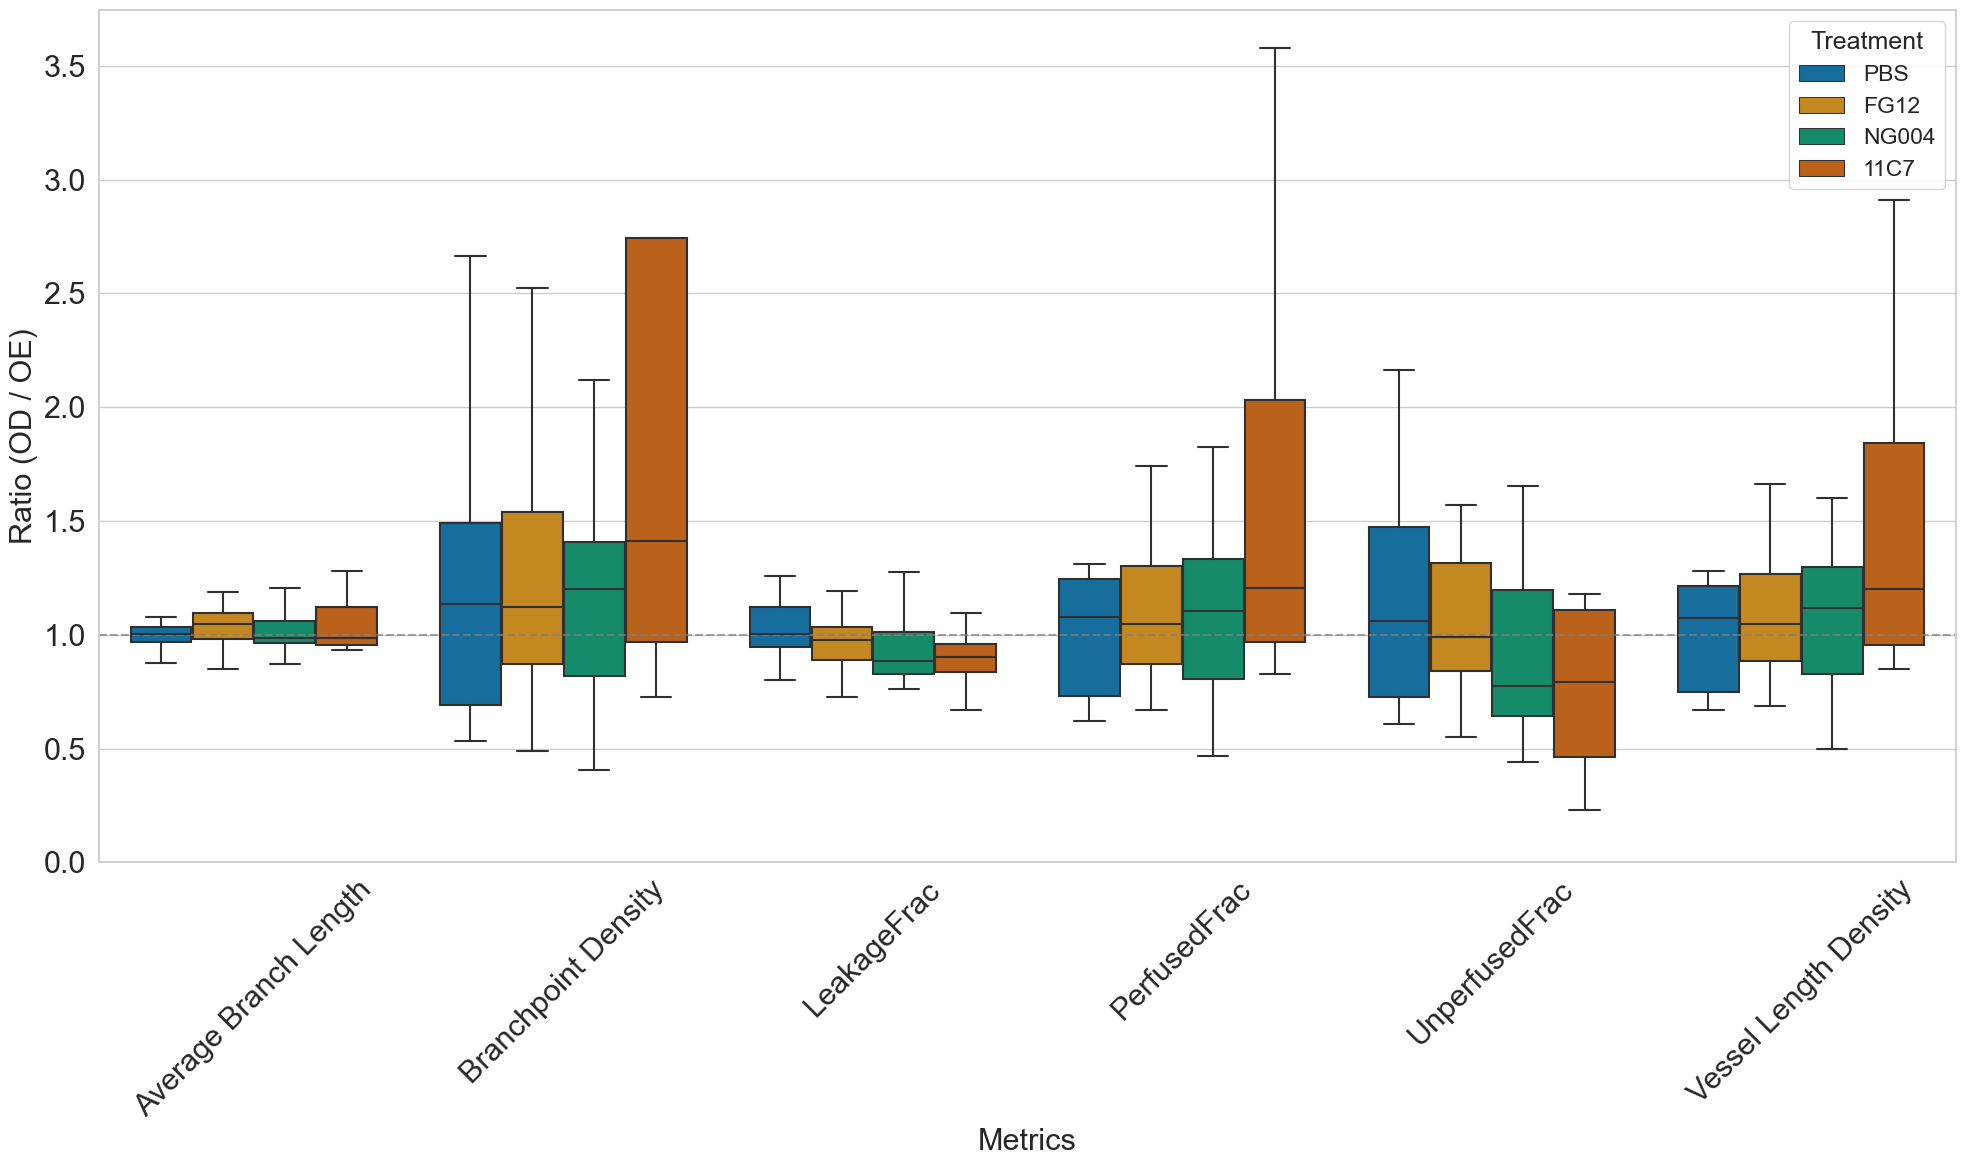

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df = df.rename(columns={'AreaFraction': 'PerfusedFrac'})

pivot_df = df.pivot_table(index=['SubjectID', 'Treatment', 'LayerNumber'],
                          columns='Eye', 
                          values=['PerfusedFrac', 'LeakageFrac', 'UnperfusedFrac', 'Average Branch Length', 'Branchpoint Density', 'Vessel Length Density'])

ratios = pivot_df.xs('OD', level='Eye', axis=1) / pivot_df.xs('OE', level='Eye', axis=1)

ratios.reset_index(inplace=True)

ratios = ratios.drop(columns=['LayerNumber'])

melted_ratios = pd.melt(ratios, id_vars=['SubjectID', 'Treatment'], var_name='Metric', value_name='Ratio')

# Plotting
plt.figure(figsize=(20, 12))  
sns.set(style="whitegrid", font_scale=1.5)  
box_plot = sns.boxplot(x='Metric', y='Ratio', hue='Treatment', data=melted_ratios, palette='colorblind', showfliers=False)

plt.ylim(0)
plt.xticks(rotation=45, fontsize=22) 
plt.yticks(fontsize=22)  
plt.xlabel('Metrics', fontsize=22)  
plt.ylabel('Ratio (OD / OE)', fontsize=22)  
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.7)  

plt.tight_layout()  
plt.show()
